In [1]:
import sys
import os

ROOT_PATH = r'C:\Users\shiqi\PycharmProjects\DSCM_fundus\deepscm'
FUNDUS_DATA_PATH = os.path.join(ROOT_PATH, r'assets\data\fundus')
BASE_LOG_PATH = os.path.join(ROOT_PATH, r'assets\model\SVIExperiment')
FIGURE_SAVE_PATH = r'C:\Users\shiqi\PycharmProjects\DSCM_fundus\deepscm\assets\data\fundus\figures_v41'

# Setup

In [2]:
%matplotlib inline
sys.path.append(ROOT_PATH)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)
torch.autograd.set_grad_enabled(False);
os.makedirs(FIGURE_SAVE_PATH, exist_ok=True)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

from deepscm.datasets.fundus import fundusDataset
data_dir = f'{FUNDUS_DATA_PATH}/test2_features.xlsx'
base_path = f'{FUNDUS_DATA_PATH}/test2_image/'
downsample = 4
fundus_test = fundusDataset(data_dir,  base_path=base_path, crop_type='center', downsample=downsample)

from deepscm.experiments.medical import fundus  # noqa: F401
from deepscm.experiments.medical.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [6]:
var_name = { 'T2D': 'T2Ds', 'sex': 's', 'age': 'a'}
value_fmt = {
    'T2D': lambda s: '{}'.format(['\mathrm{normal}', '\mathrm{T2D}'][int(s)]),
    'age': lambda s: rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['\mathrm{female}', '\mathrm{male}'][int(s)])
}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        all_interventions = ', '.join([f'{var_name[k]}={value_fmt[k](v)}' for k, v in intervention.items()])
        return f"$do({all_interventions})$"

In [7]:
def prep_data(batch):
    x = batch['image'].cuda().unsqueeze(0)* 255.
    age = batch['age'].cuda().unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].cuda().unsqueeze(0).unsqueeze(0).float()
    T2D = batch['T2D'].cuda().unsqueeze(0).float()

    x = x.float()

    return {'x': x, 'age': age, 'sex': sex, 'T2D': T2D}

# Loaded Models

In [10]:
models = {}
loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_{version}/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cuda'))
        hparams = ckpt['hyper_parameters']
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

# Dataset Samples

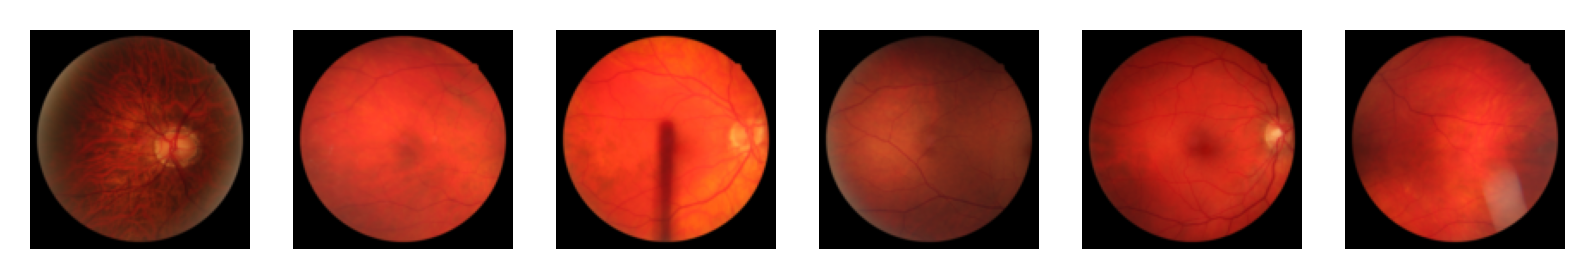

In [13]:
num_cols = 6
num_rows = 1
num = num_cols * num_rows

fig = plt.figure(figsize=(num_cols * 1.1, num_rows * 1.1))
gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

save_name = 'fundus_samples'

candidates=[37, 30, 600, 668, 715,3035]
for i in range(num):
    m=candidates[i]
    d = (fundus_test[m]['image'] * 255).int()
    
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    ax.imshow(d.squeeze().permute(1,2,0).numpy())
    ax.axis('off')

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)
plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)
plt.show()

# Unconditional Samples

ConditionalVISEM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


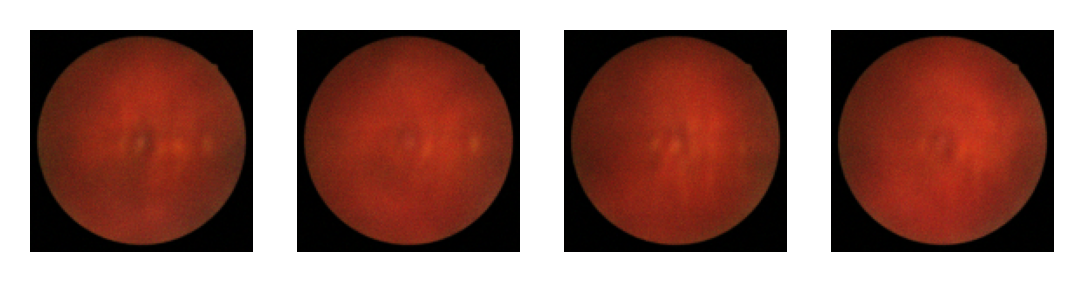

In [11]:
num_cols = 4
num_rows = 1
num = num_cols * num_rows


for exp in loaded_models.keys():
    print(exp)
    model = loaded_models[exp].cuda()
    samples = model.sample(num)
        
    samples = {
        'x': samples[0],
    }
    
    save_name = f'{exp}_uncond_samples'

    fig = plt.figure(figsize=(num_cols * 1.1, num_rows * 1.1))
    gs = fig.add_gridspec(num_rows, num_cols, wspace=.2, hspace=.2)

    for i in range(num):
        x = samples['x'][i].round().int().squeeze().permute(1,2,0).cpu().numpy()
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.imshow(x)
        ax.axis('off')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)
    
    plt.show()

# Conditional Samples

ConditionalVISEM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


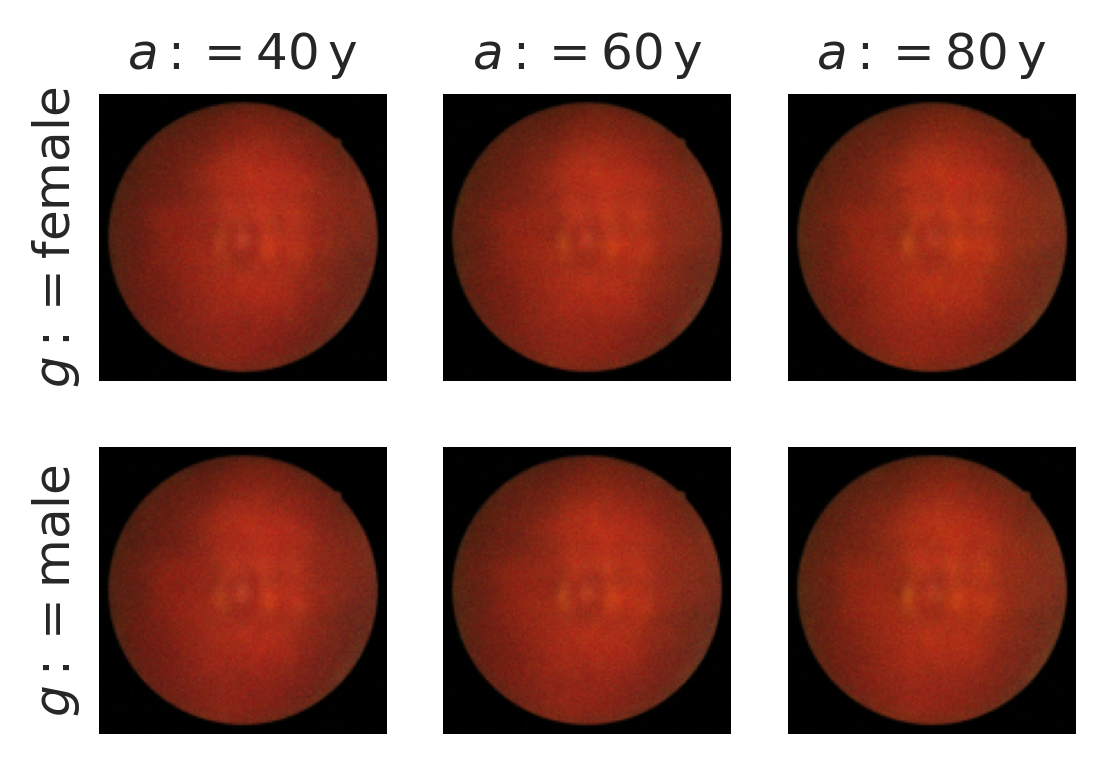

In [26]:
exp = 'ConditionalVISEM'

print(exp)

a_range = [40., 60., 80.]
s_range = [0. , 1.]

samples = {
    'x': [],
    'age': [],
    'sex': [],

}

save_name = f'{exp}_cond_samples'

num_ex = 1
num_cols = len(a_range)
num_rows = len(s_range)
num = num_ex * num_cols * num_rows

fig = plt.figure(figsize=(num_ex * num_cols * 1.4, num_rows * 1.4))

width_ratios = [0.1 if ((i + 1) % (num_cols + 1)) == 0 else 1 for i in range(num_ex * num_cols + num_ex - 1)]
gs = fig.add_gridspec(num_rows, num_ex * num_cols + num_ex - 1, wspace=.2, hspace=.2, width_ratios=width_ratios)

z = loaded_models[exp].sample(1)[1]
for _ in range(num_ex):
    # z = loaded_models[exp].sample(1)[1]

    for i, sex in enumerate(s_range):
        for j, age in enumerate(a_range):
            age = torch.tensor([[age]])
            sex = torch.tensor([[sex]])
            data = {'z': z, 'age': age, 'sex': sex}

            x, *_ = pyro.condition(loaded_models[exp].sample, data=data)(1)
            samples['x'] += [x]
            samples['age'] += [age]
            samples['sex'] += [sex]



for i in range(num):
    cur_ex = i // (num_cols * num_rows)
    cur_row = (i - cur_ex * num_cols * num_rows) // num_cols
    cur_col = i % num_cols

    x = samples['x'][i].round().int().squeeze().permute(1,2,0).cpu().numpy()

    ax = fig.add_subplot(gs[cur_row, cur_col + cur_ex * (num_cols + 1)])
    ax.imshow(x)
    if cur_col == 0 and cur_ex == 0:
        sex = samples['sex'][i].item()
        ax.set_ylabel('$g:={}$'.format(value_fmt['sex'](sex)),
                      fontsize=mpl.rcParams['axes.titlesize'])
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
    if cur_row == 0:
        age = samples['age'][i].item()
        ax.set_title('$a:={}$'.format(value_fmt['age'](age)))
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

ConditionalVISEM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


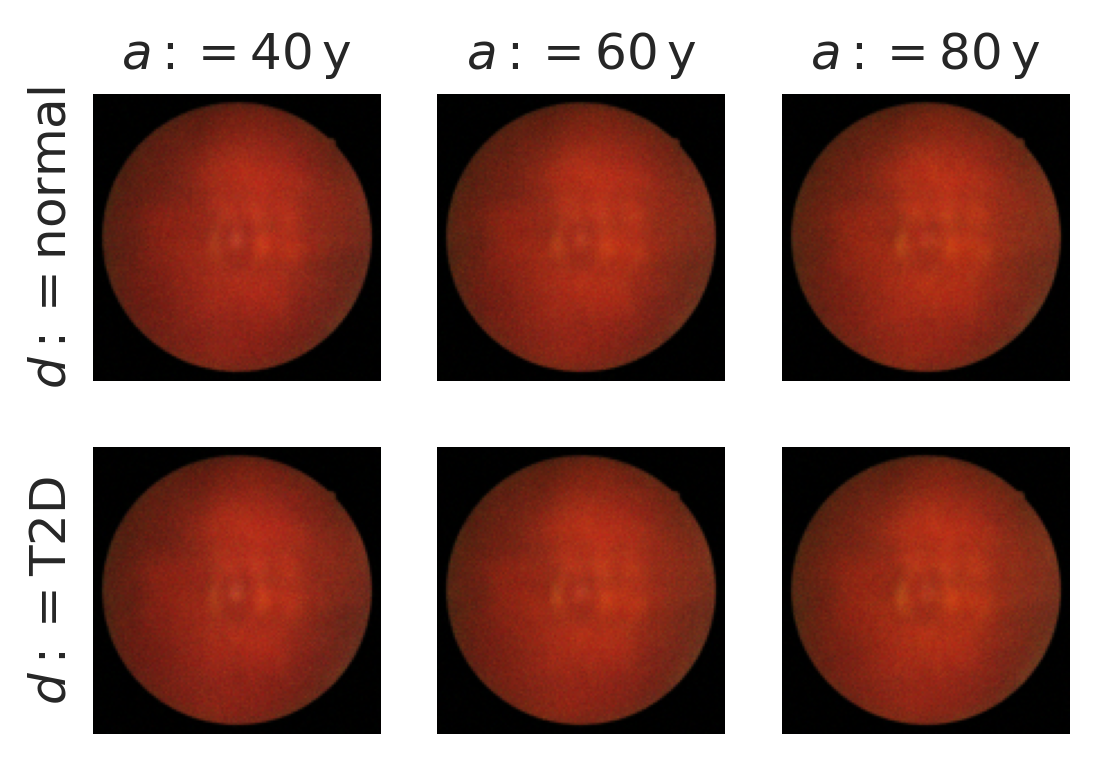

In [27]:
exp = 'ConditionalVISEM'

print(exp)

a_range = [40., 60., 80.]
s_range = [0. , 1.]

samples = {
    'x': [],
    'age': [],
    'T2D': [],

}

save_name = f'{exp}_cond_samples'

num_ex = 1
num_cols = len(a_range)
num_rows = len(s_range)
num = num_ex * num_cols * num_rows

fig = plt.figure(figsize=(num_ex * num_cols * 1.4, num_rows * 1.4))

width_ratios = [0.1 if ((i + 1) % (num_cols + 1)) == 0 else 1 for i in range(num_ex * num_cols + num_ex - 1)]
gs = fig.add_gridspec(num_rows, num_ex * num_cols + num_ex - 1, wspace=.2, hspace=.2, width_ratios=width_ratios)


for _ in range(num_ex):
    # z = loaded_models[exp].sample(1)[1]

    for i, T2D in enumerate(s_range):
        for j, age in enumerate(a_range):
            age = torch.tensor([[age]])
            T2D = torch.tensor([[T2D]])
            data = {'z': z, 'age': age, 'T2D': T2D}

            x, *_ = pyro.condition(loaded_models[exp].sample, data=data)(1)
            samples['x'] += [x]
            samples['age'] += [age]
            samples['T2D'] += [T2D]



for i in range(num):
    cur_ex = i // (num_cols * num_rows)
    cur_row = (i - cur_ex * num_cols * num_rows) // num_cols
    cur_col = i % num_cols

    x = samples['x'][i].round().int().squeeze().permute(1,2,0).cpu().numpy()

    ax = fig.add_subplot(gs[cur_row, cur_col + cur_ex * (num_cols + 1)])
    ax.imshow(x)
    if cur_col == 0 and cur_ex == 0:
        T2D = samples['T2D'][i].item()
        ax.set_ylabel('$d:={}$'.format(value_fmt['T2D'](T2D)),
                      fontsize=mpl.rcParams['axes.titlesize'])
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
    if cur_row == 0:
        age = samples['age'][i].item()
        ax.set_title('$a:={}$'.format(value_fmt['age'](age)))
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

# Reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ConditionalVISEM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


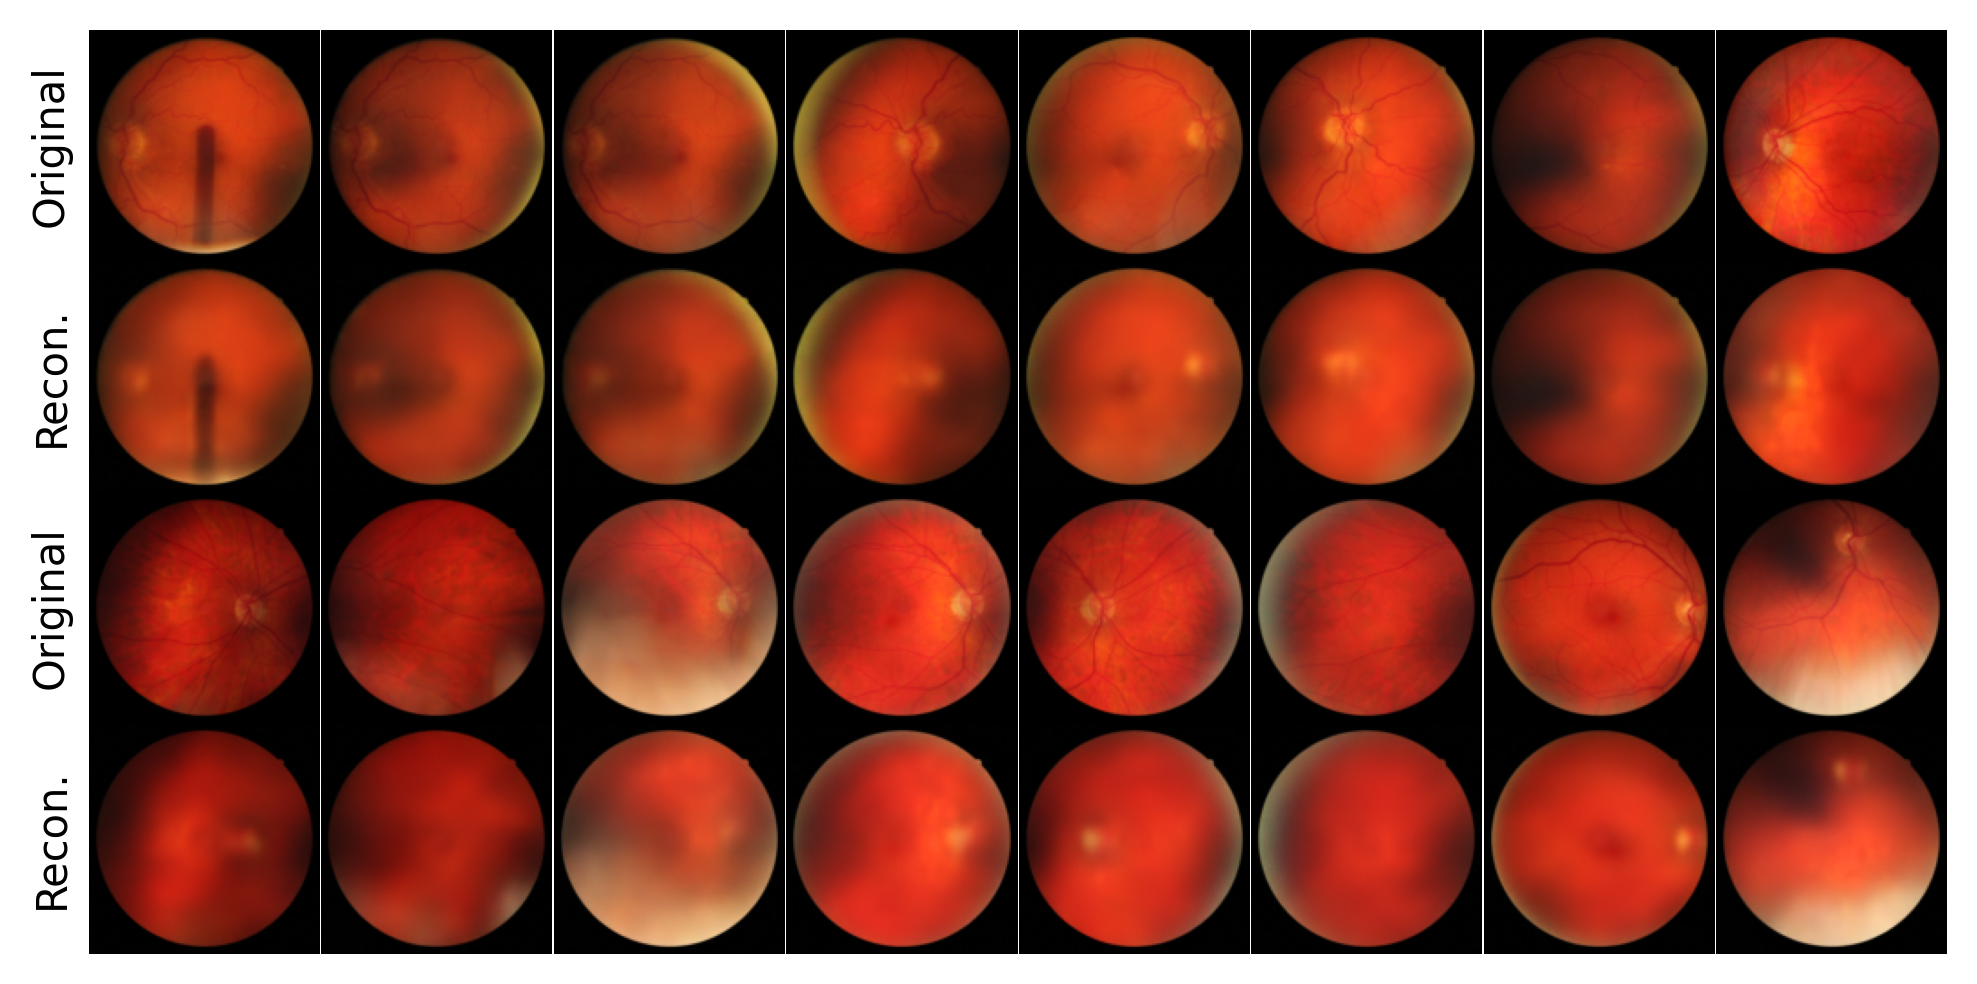

In [42]:
num_samples = 8
num_rows = 2

save_name = 'reconstructions'

fig = plt.figure(figsize=(num_samples * 1., 2. * num_rows))

gs = fig.add_gridspec(2 * num_rows, num_samples, wspace=0., hspace=0.0)
reconstructions = []
for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples

    orig_data = prep_data(fundus_test[i])
    
    img = (fundus_test[i]['image'] * 255).round().int().squeeze().permute(1,2,0).cpu().numpy()
    recon = loaded_models[exp].reconstruct(**orig_data, num_particles=32).squeeze().permute(1,2,0).round().int().cpu().numpy()
    reconstructions.append(recon)
    
    ax = fig.add_subplot(gs[row * 2, col])
    ax.imshow(img)
    if col == 0:
        ax.set_ylabel('Original')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')
        
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

exp = 'ConditionalVISEM'
print(exp)
# reconstructions = torch.load(f'{BASE_LOG_PATH}/{exp}/version_{version}/reconstruction.pt')

for i in range(num_samples * num_rows):
    col = i % num_samples
    row = i // num_samples

    img = reconstructions[i]

    ax = fig.add_subplot(gs[row * 2 + 1, col])
    ax.imshow(img)
    if col == 0:
        ax.set_ylabel('Recon.')
        for s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['left', 'top', 'right']:
            ax.spines[s].set_visible(False)
        for s in ['top', 'right', 'bottom']:
            ax.spines[s].set_visible(False)
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
        plt.setp(ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.axis('off')

    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
            
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png", bbox_inches='tight', pad_inches=0)

plt.show()

# Associational inference

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

model_name = 'ConditionalVISEM'
save_name = ''
def pgm_model(n):
    with pyro.plate('observations', n):
        model =loaded_models[model_name].cuda()
        return model.pgm_model()
m = pgm_model(10000)
pgm_dic = {'age':m[0].round().squeeze().cpu(), 'sex':m[1].int().squeeze().cpu(), 'Diabetes status':m[2].cpu()}
df_pgm =pd.DataFrame.from_dict(pgm_dic)
df_pgm['Gender'] =df_pgm['sex']

csv_path = r'C:\Users\shiqi\PycharmProjects\DSCM_fundus\deepscm\deepscm\datasets\split_dir4\train_features.xlsx'
dtype_dic = {'Filename': str, 'RandomID': str, 'age': int, 'sex': int, 'T2D': int, 'HT': int}
df = pd.read_excel(csv_path, engine='openpyxl', converters=dtype_dic)
df["Diabetes status"] = df["T2D"]
df['Gender'] =df['sex']

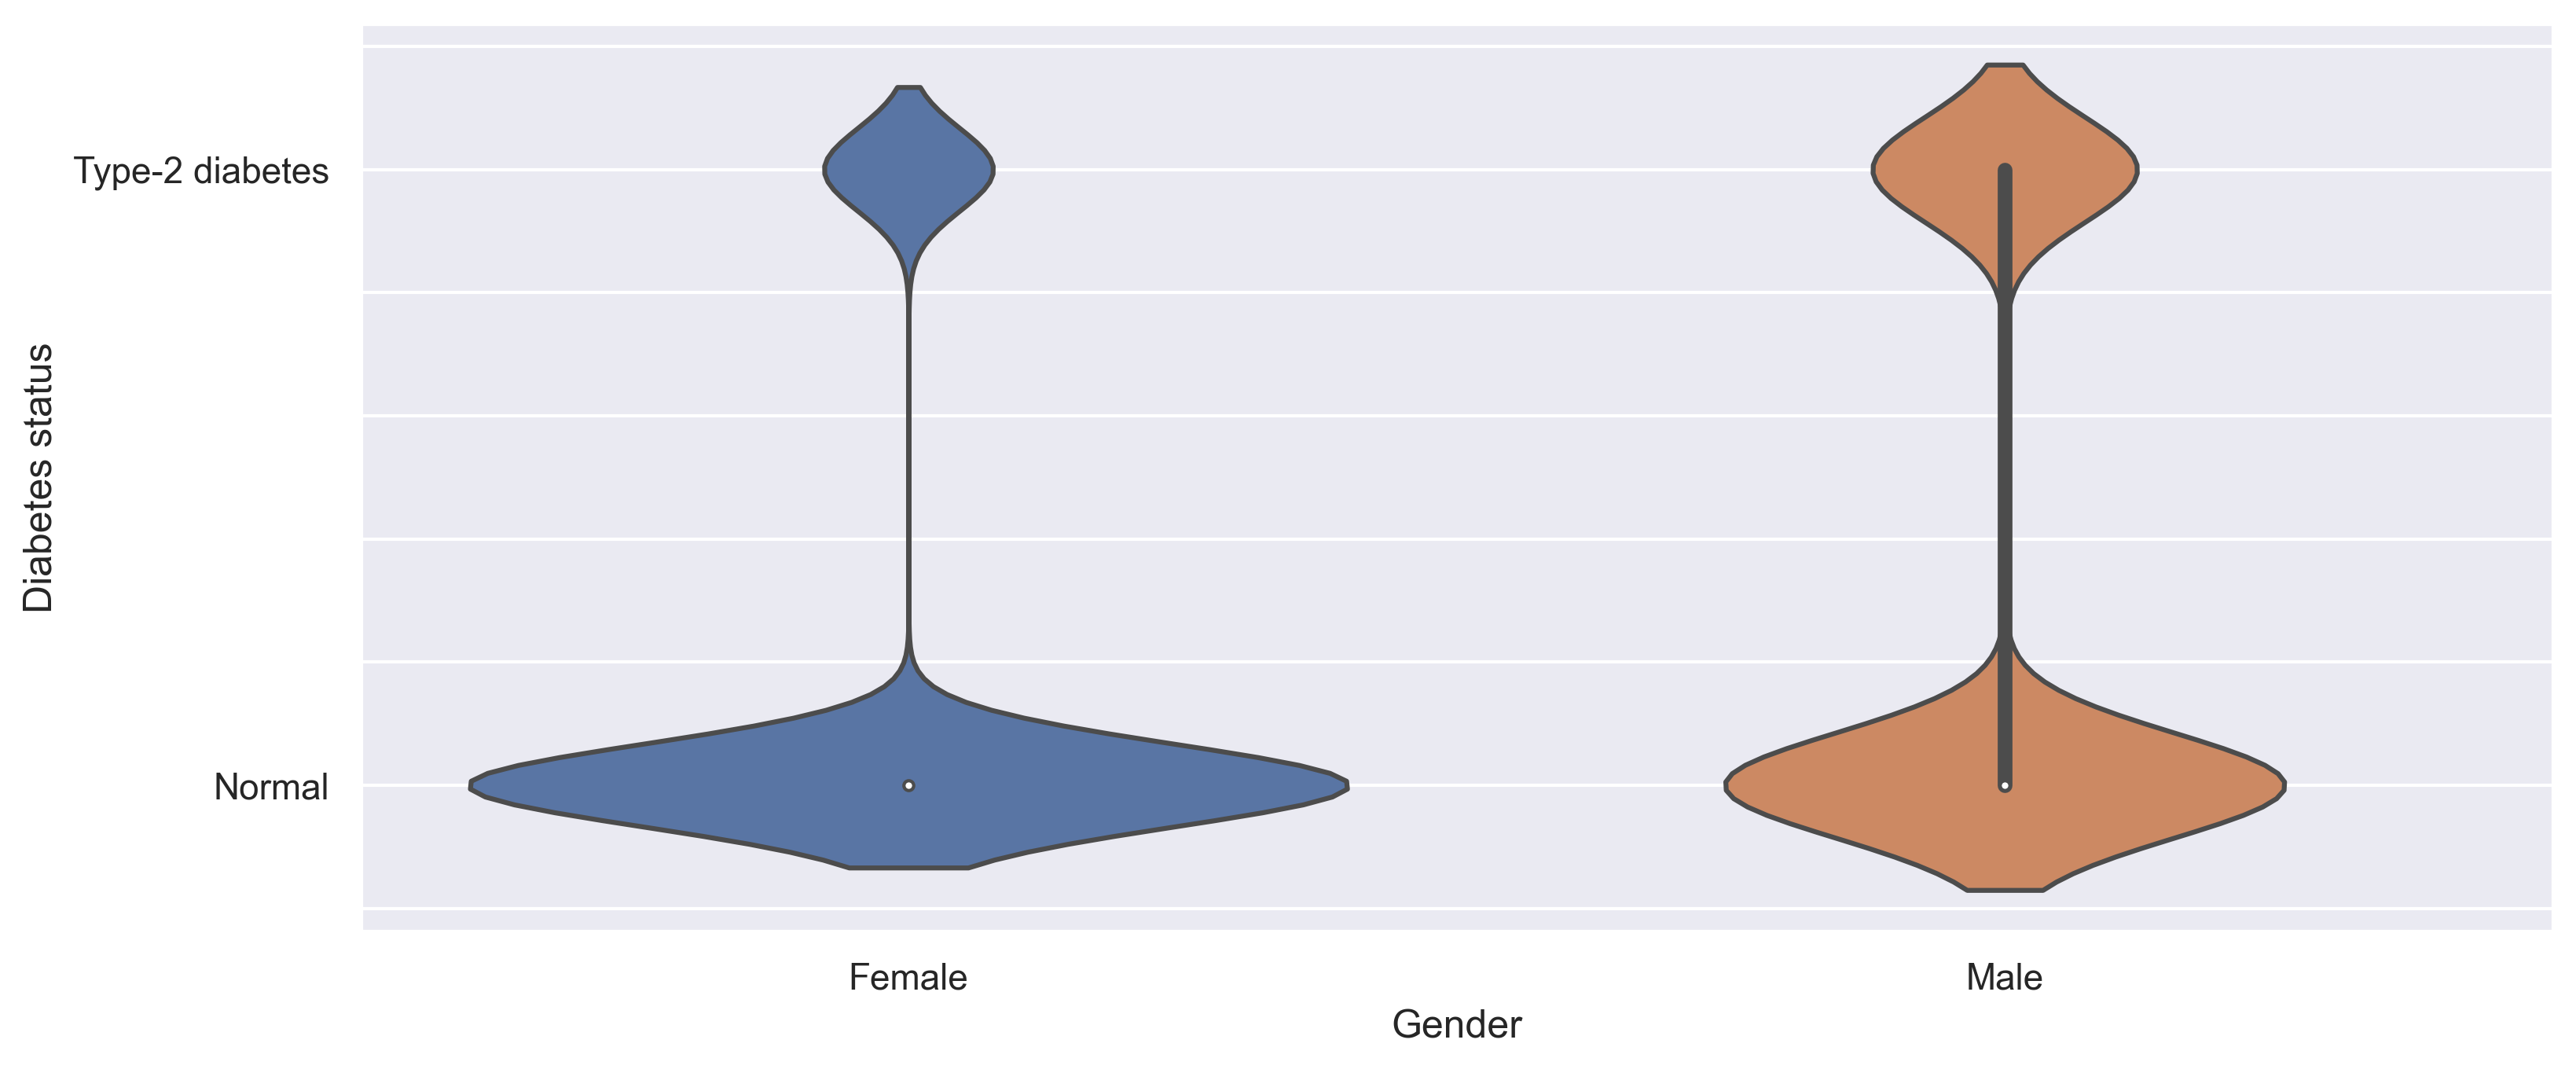

In [69]:
fig = plt.figure(figsize=(12,5))
save_name = 'model_joint_g_d'
# kde_data = sns.violinplot(data=df, x="Diabetes status" , y="age",  hue= "Gender" )
# kde_data.set_xticklabels(['Normal','Type-2 diabetes'] )
# kde_data.set_ylim([30,85])
# kde_data.legend(handles=kde_data.legend_.legendHandles, labels=['Female','Male'], loc="lower center")

# kde_data = sns.violinplot(data=df, x="Diabetes status" , y="age")
# kde_data.set_xticklabels(['Normal','Type-2 diabetes'])
# kde_data.set_ylim([30,85])

# kde_data = sns.violinplot(data=df, x="Gender" , y="age")
# kde_data.set_xticklabels(['Female','Male'])
# kde_data.set_ylim([30,85])

# kde_data  = sns.violinplot(data=df, x="Gender"  , y="Diabetes status" )
# kde_data.set_xticklabels(['Female','Male'])
# kde_data.set_yticklabels(['','', 'Normal', '','','','','Type-2 diabetes', ''])


# kde_pgm  = sns.violinplot(data=df_pgm, x="Diabetes status", y="age", hue= "Gender" )
# kde_pgm.set_xticklabels(['Normal','Type-2 diabetes'] )
# kde_pgm.set_ylim([30,85])
# kde_pgm.legend(handles=kde_pgm.legend_.legendHandles, labels=['Female','Male'], loc="lower center")

# kde_pgm  = sns.violinplot(data=df_pgm, x="Diabetes status" , y="age")
# kde_pgm.set_xticklabels(['Normal','Type-2 diabetes'])
# kde_pgm.set_ylim([30,85])

kde_pgm  = sns.violinplot(data=df_pgm, x="Gender"  , y="Diabetes status" )
kde_pgm.set_xticklabels(['Female','Male'])
kde_pgm.set_yticklabels(['','', 'Normal', '','','','','Type-2 diabetes', ''])


# kde_data = sns.jointplot( data = df, x="age", y="Type-2 diabetes", hue="Gender",kind="kde", xlim=[20,100], ylim =[-0.4, 1.4])
# kde_pgm = sns.jointplot( data = df_pgm, x="age", y="Type-2 diabetes", hue="Gender", kind="kde", xlim=[20,100], ylim =[-0.4, 1.4])


# gs.tight_layout(fig)

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png")
# plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.pdf", bbox_inches='tight', pad_inches=0)


# Interventional inference

In [88]:
d = torch.zeros(1000,1)
data = {'T2D': d.int()}
m = pyro.condition(loaded_models[exp].sample, data=data)(1000)
age_d0=m[2].squeeze().cpu().int()

d = torch.ones(1000,1)
data= {'T2D': d.int()}
m = pyro.condition(loaded_models[exp].sample, data=data)(1000)
age_d1=m[2].squeeze().cpu().int()

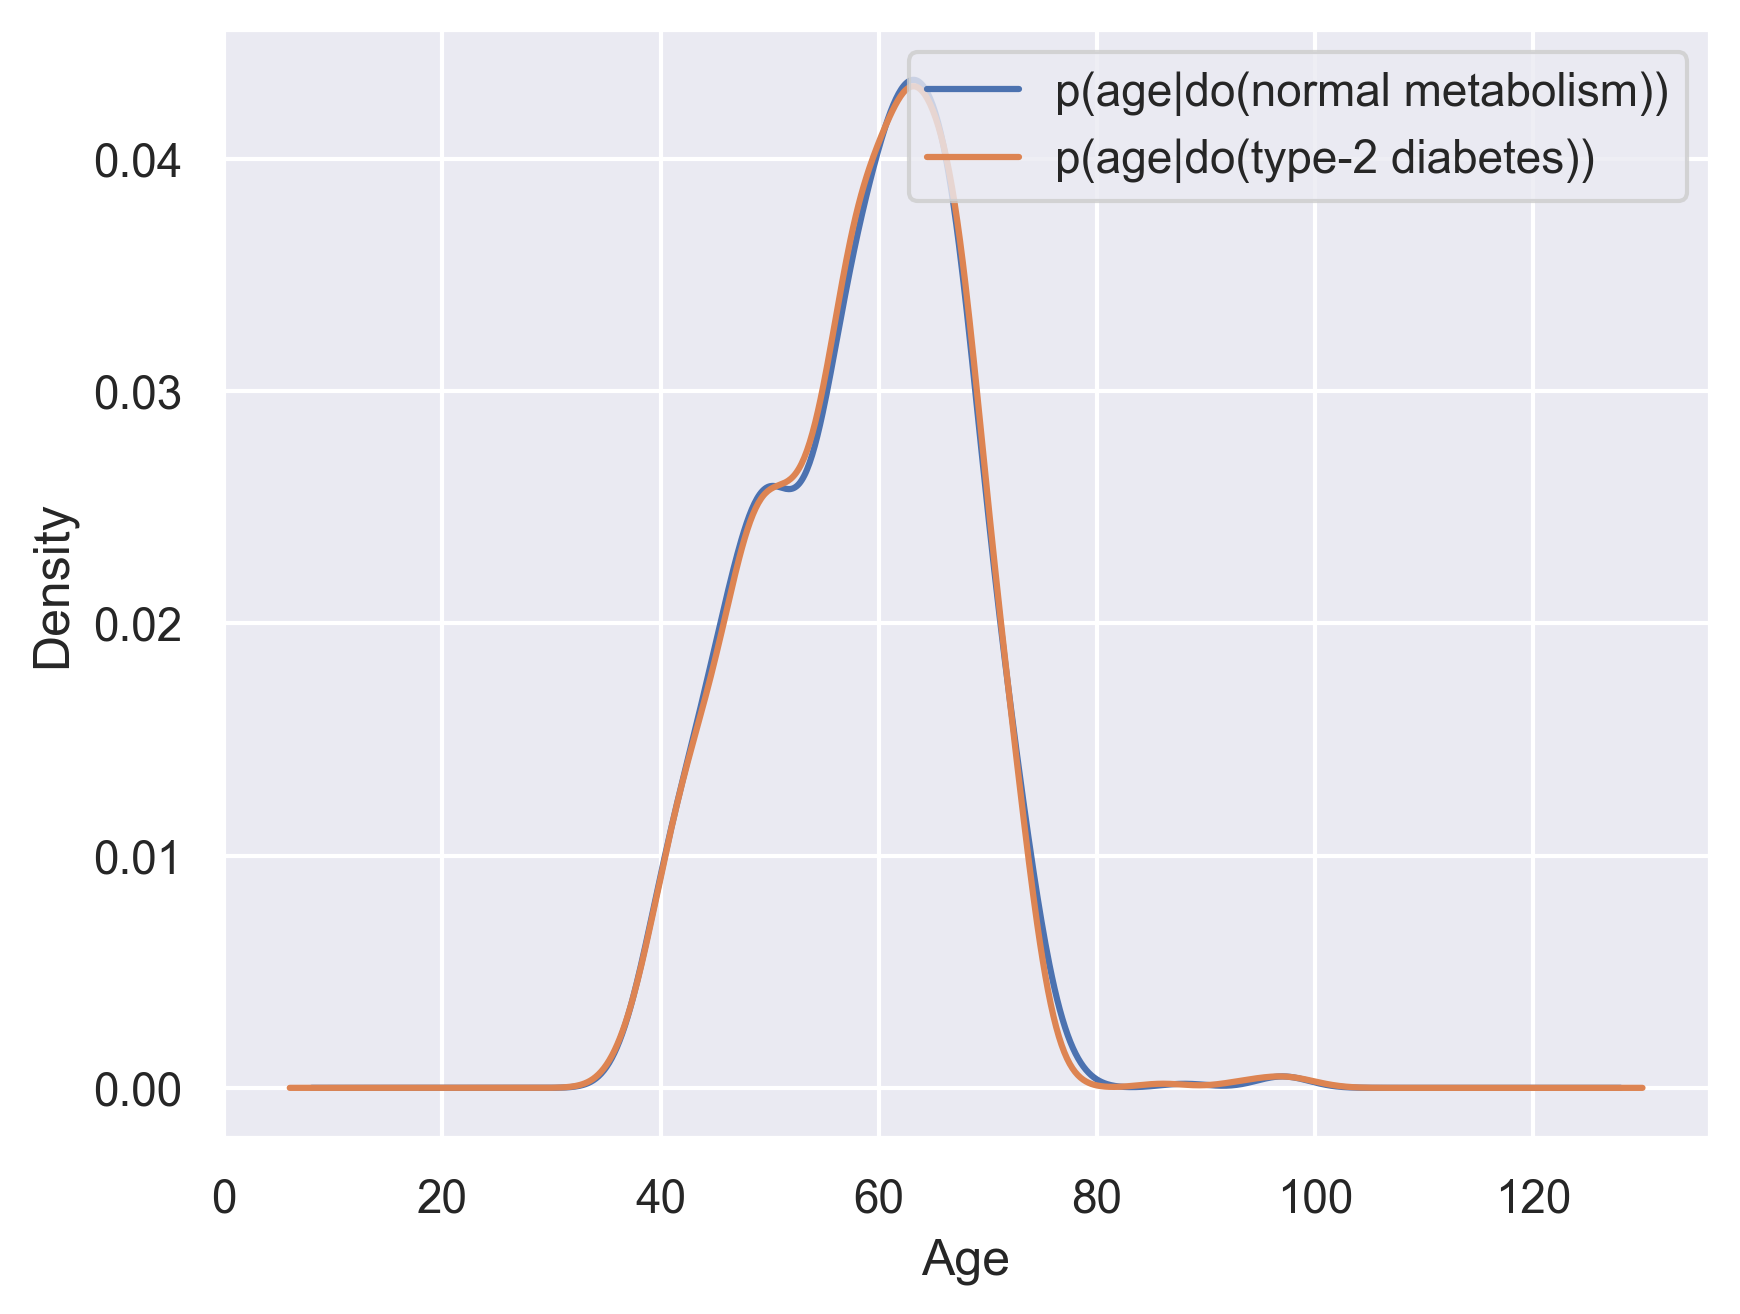

In [135]:
save_name = 'p_a_do_d'
age_d01 = {'p(age|do(normal metabolism))': age_d0, r'p(age|do(type-2 diabetes))': age_d1}
df_age_d01 = pd.DataFrame.from_dict(age_d01)
df_age_d01.plot.kde()
plt.xlabel('Age')
plt.legend(title="", loc='upper right')

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png")

In [161]:
a = torch.ones(10000,1)*40
data = {'age': a}
m = pyro.condition(loaded_models[exp].sample, data=data)(10000)
d_age40=m[4].squeeze().cpu().int()

a = torch.ones(10000,1)*60
data = {'age': a}
m = pyro.condition(loaded_models[exp].sample, data=data)(10000)
d_age60=m[4].squeeze().cpu().int()

a = torch.ones(10000,1)*80
data = {'age': a}
m = pyro.condition(loaded_models[exp].sample, data=data)(10000)
d_age80=m[4].squeeze().cpu().int()

C:\Users\shiqi\AppData\Local\Temp\ipykernel_22720\4171601919.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d_age['age'][10000:20000]=60
C:\Users\shiqi\AppData\Local\Temp\ipykernel_22720\4171601919.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d_age['age'][20000:]=80


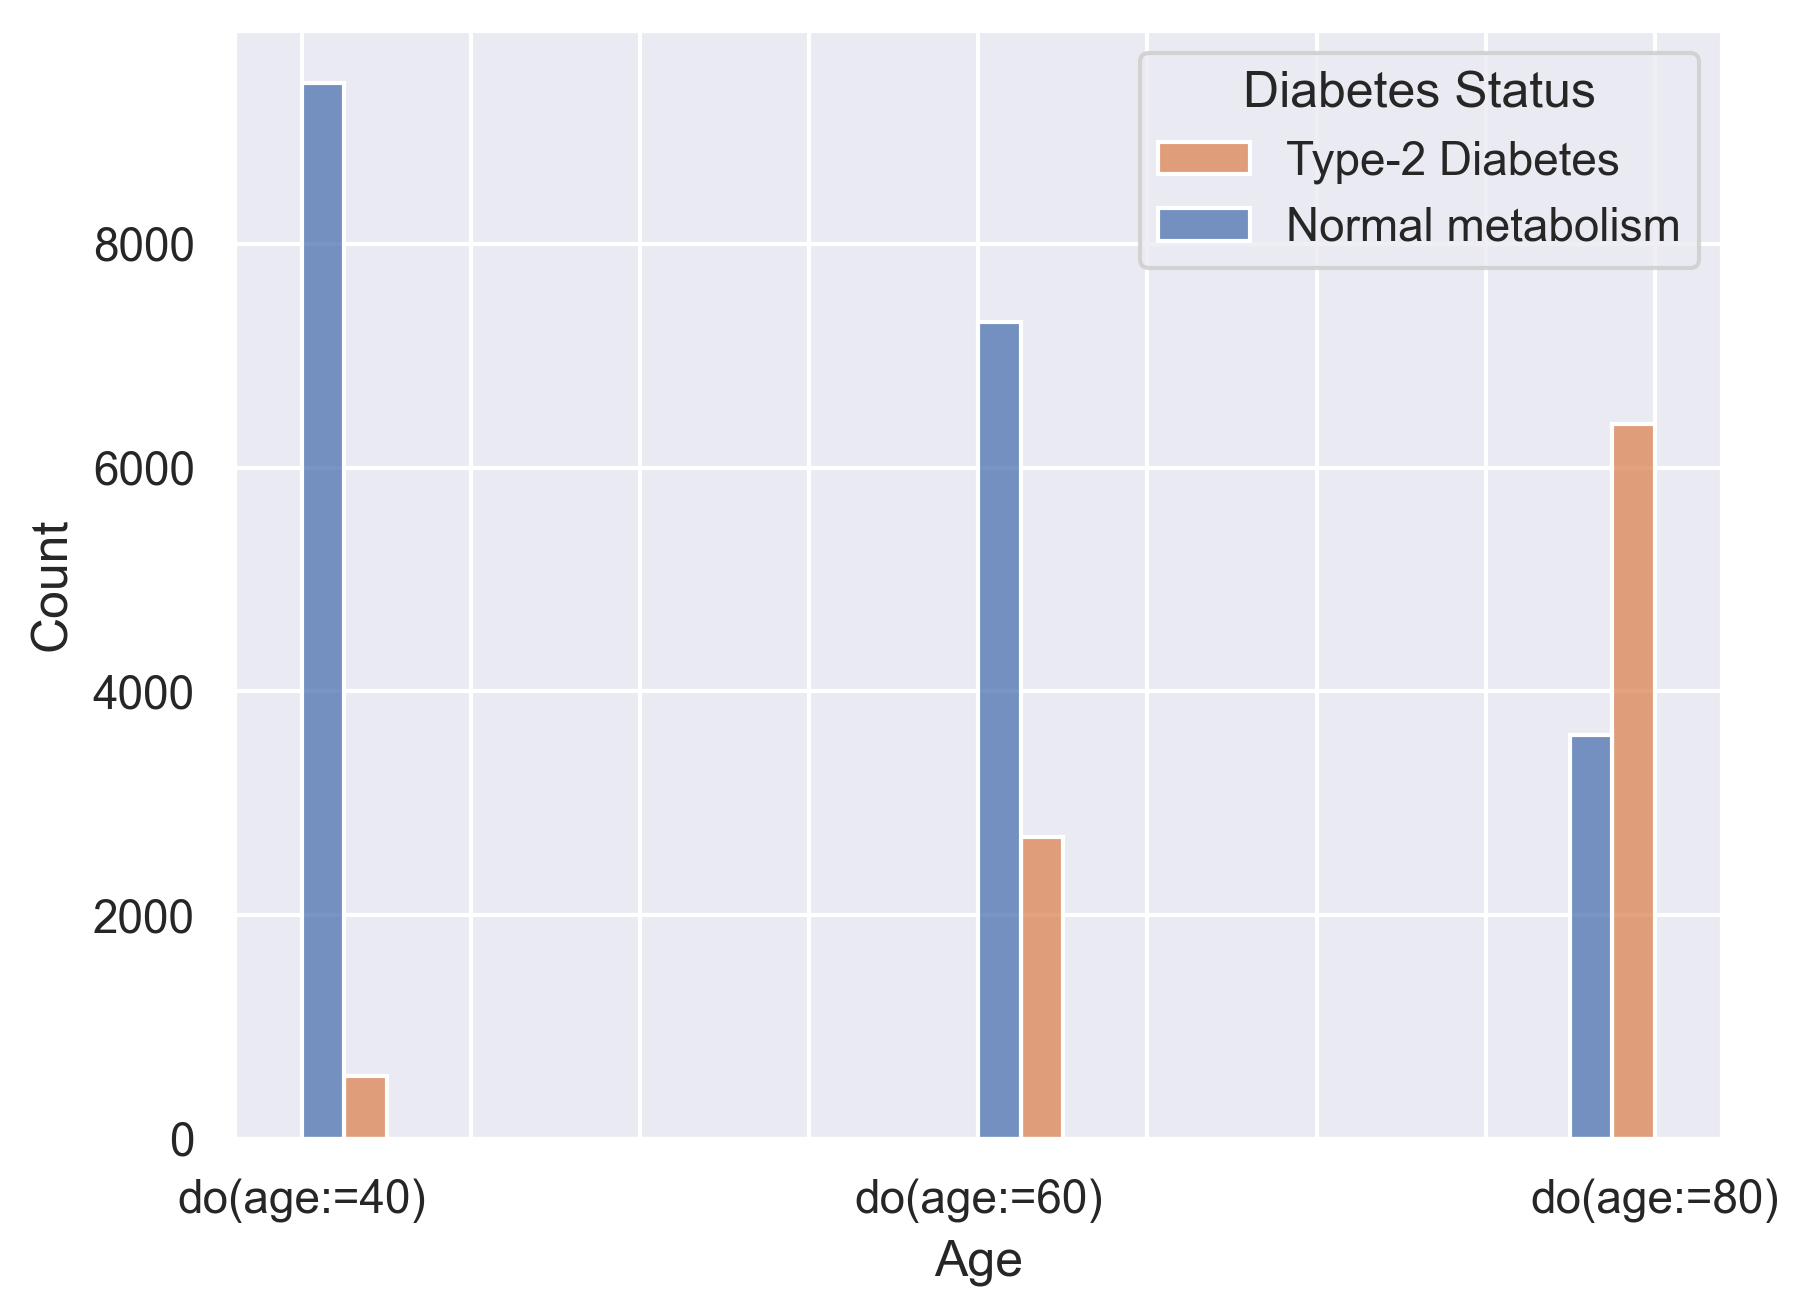

In [170]:
save_name = 'p_d_do_a'
d_age = torch.cat([d_age40, d_age60, d_age80])
df_d_age = pd.DataFrame.from_dict({"Type-2 diabetes": d_age})
df_d_age['age']=40
df_d_age['age'][10000:20000]=60
df_d_age['age'][20000:]=80
ax = sns.histplot(data=df_d_age, x="age", hue="Type-2 diabetes", multiple="dodge", stat="count")
ax.set(xlabel='Age')
ax.set_xticklabels(['', 'do(age:=40)', '', '','','do(age:=60)','','','', 'do(age:=80)', ''])
plt.legend(title="Diabetes Status", loc='upper right', labels=['Type-2 Diabetes', 'Normal metabolism'])

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png")

In [134]:
d = torch.zeros(1)
data = {'T2D': d.int()}
m = pyro.condition(loaded_models[exp].pgm_model, data=data)
g_d0=[]
with pyro.plate('observations', 10000):
    g_d0.append(m()[1])

d = torch.ones(1)
data = {'T2D': d.int()}
m = pyro.condition(loaded_models[exp].pgm_model, data=data)
g_d1=[]
with pyro.plate('observations', 10000):
    g_d1.append(m()[1])

g_d0= g_d0[0].flatten().cpu()
g_d1= g_d1[0].flatten().cpu()

C:\Users\shiqi\AppData\Local\Temp\ipykernel_22720\700720219.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g_d['T2D'][10000:20000]=1


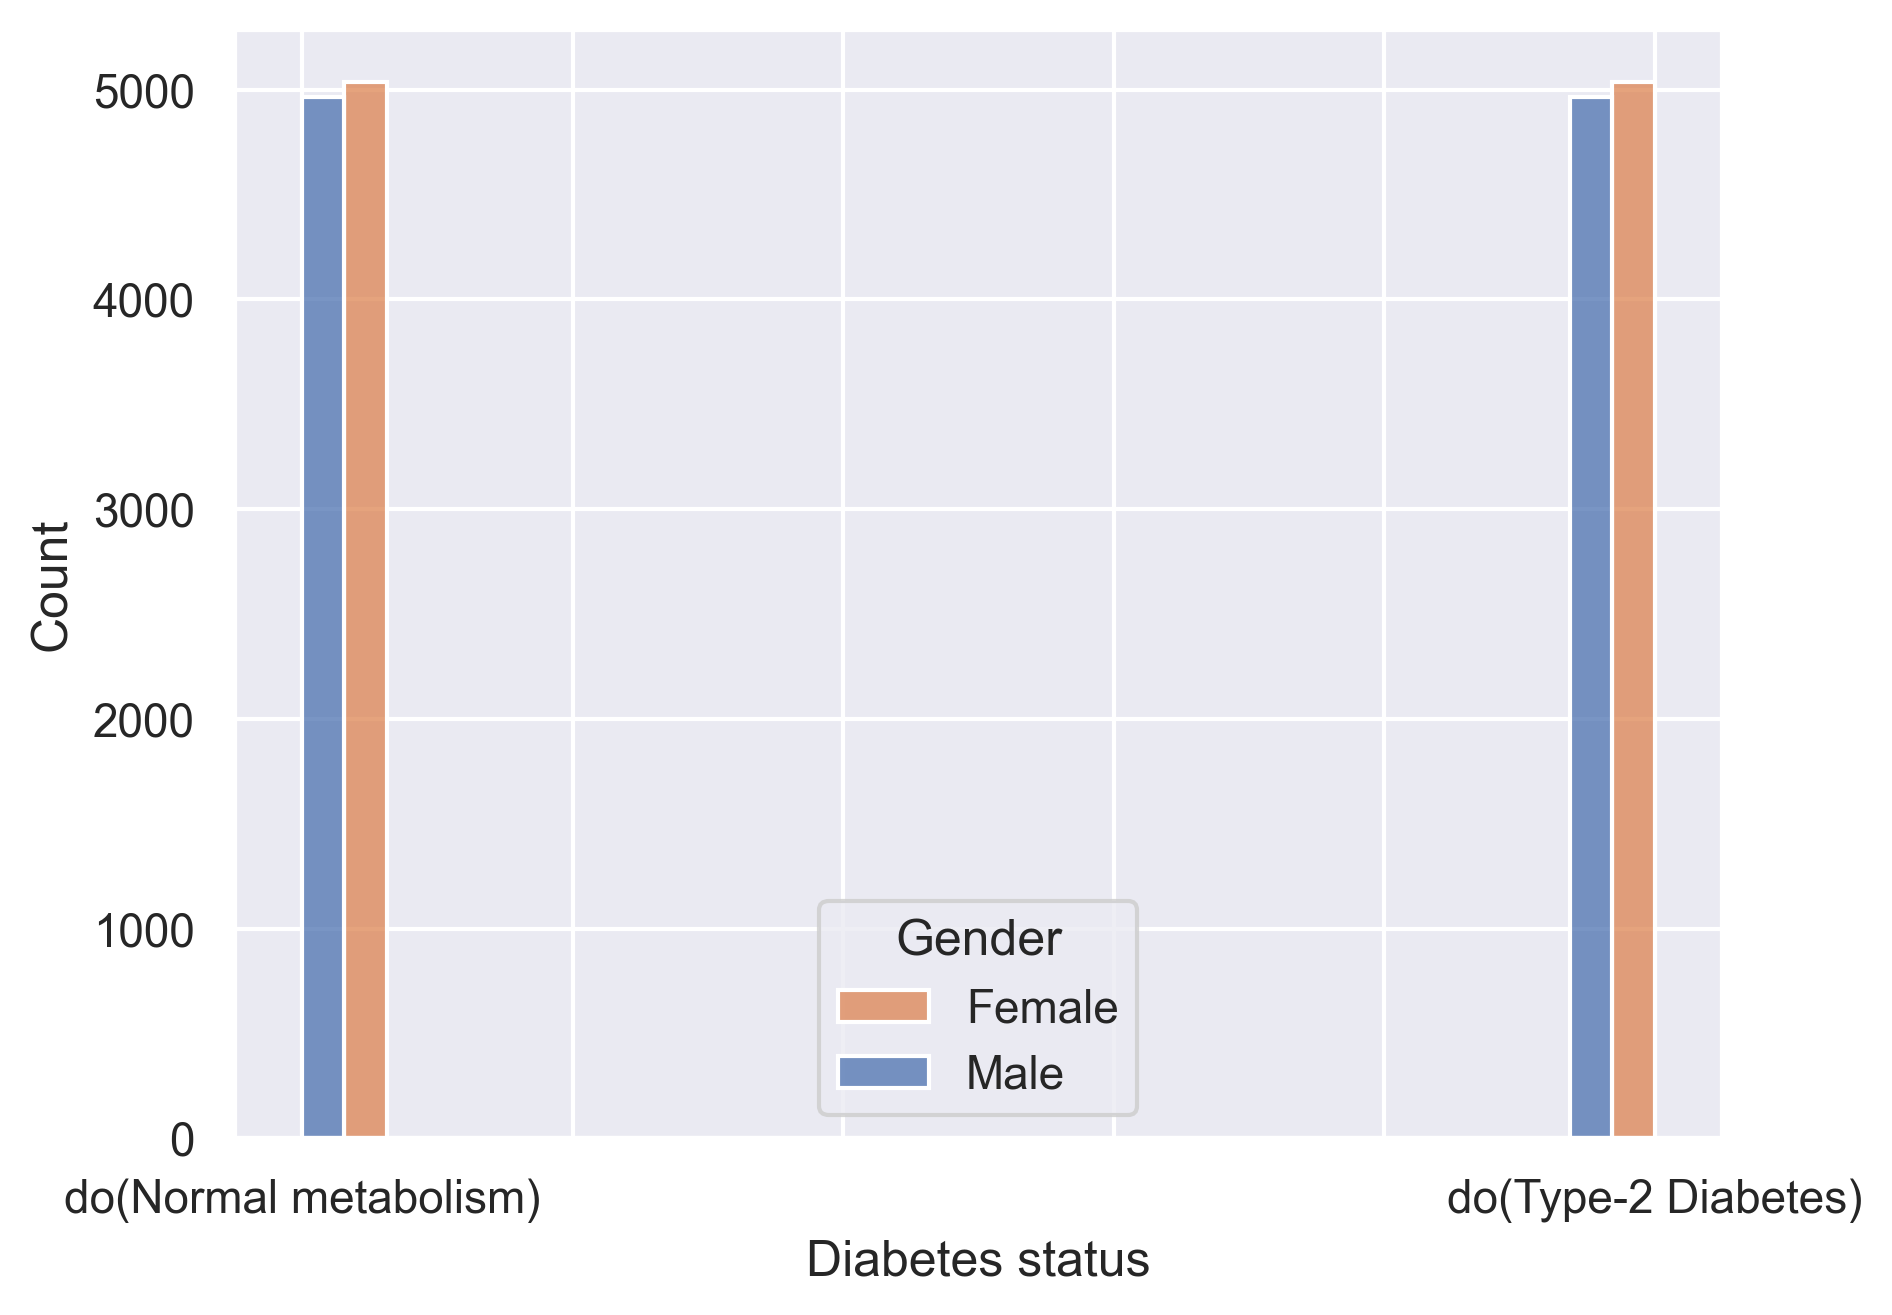

In [139]:
save_name = 'p_g_do_d'
g_d = torch.cat([g_d0, g_d1])
df_g_d = pd.DataFrame.from_dict({"Gender": g_d})
df_g_d['T2D']=0
df_g_d['T2D'][10000:20000]=1
ax = sns.histplot(data=df_g_d, x="T2D", hue="Gender", multiple="dodge", stat="count")
ax.set(xlabel='Diabetes status')
ax.set_xticklabels(['', 'do(Normal metabolism)', '', '','', '', 'do(Type-2 Diabetes)', ''])
plt.legend(title='Gender', loc='lower center', labels=['Female', 'Male'])

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png")

In [156]:
g = torch.zeros(10000,1)
data = {'sex': g.int()}
m = pyro.condition(loaded_models[exp].pgm_model, data=data)
d_g0=[]

with pyro.plate('observations', 10000):
    d_g0.append(m()[2])

d = torch.ones(10000,1)
data = {'sex': d.int()}
m = pyro.condition(loaded_models[exp].pgm_model, data=data)
d_g1=[]

with pyro.plate('observations', 10000):
    d_g1.append(m()[2])

d_g0= d_g0[0].flatten().cpu()
d_g1= d_g1[0].flatten().cpu()

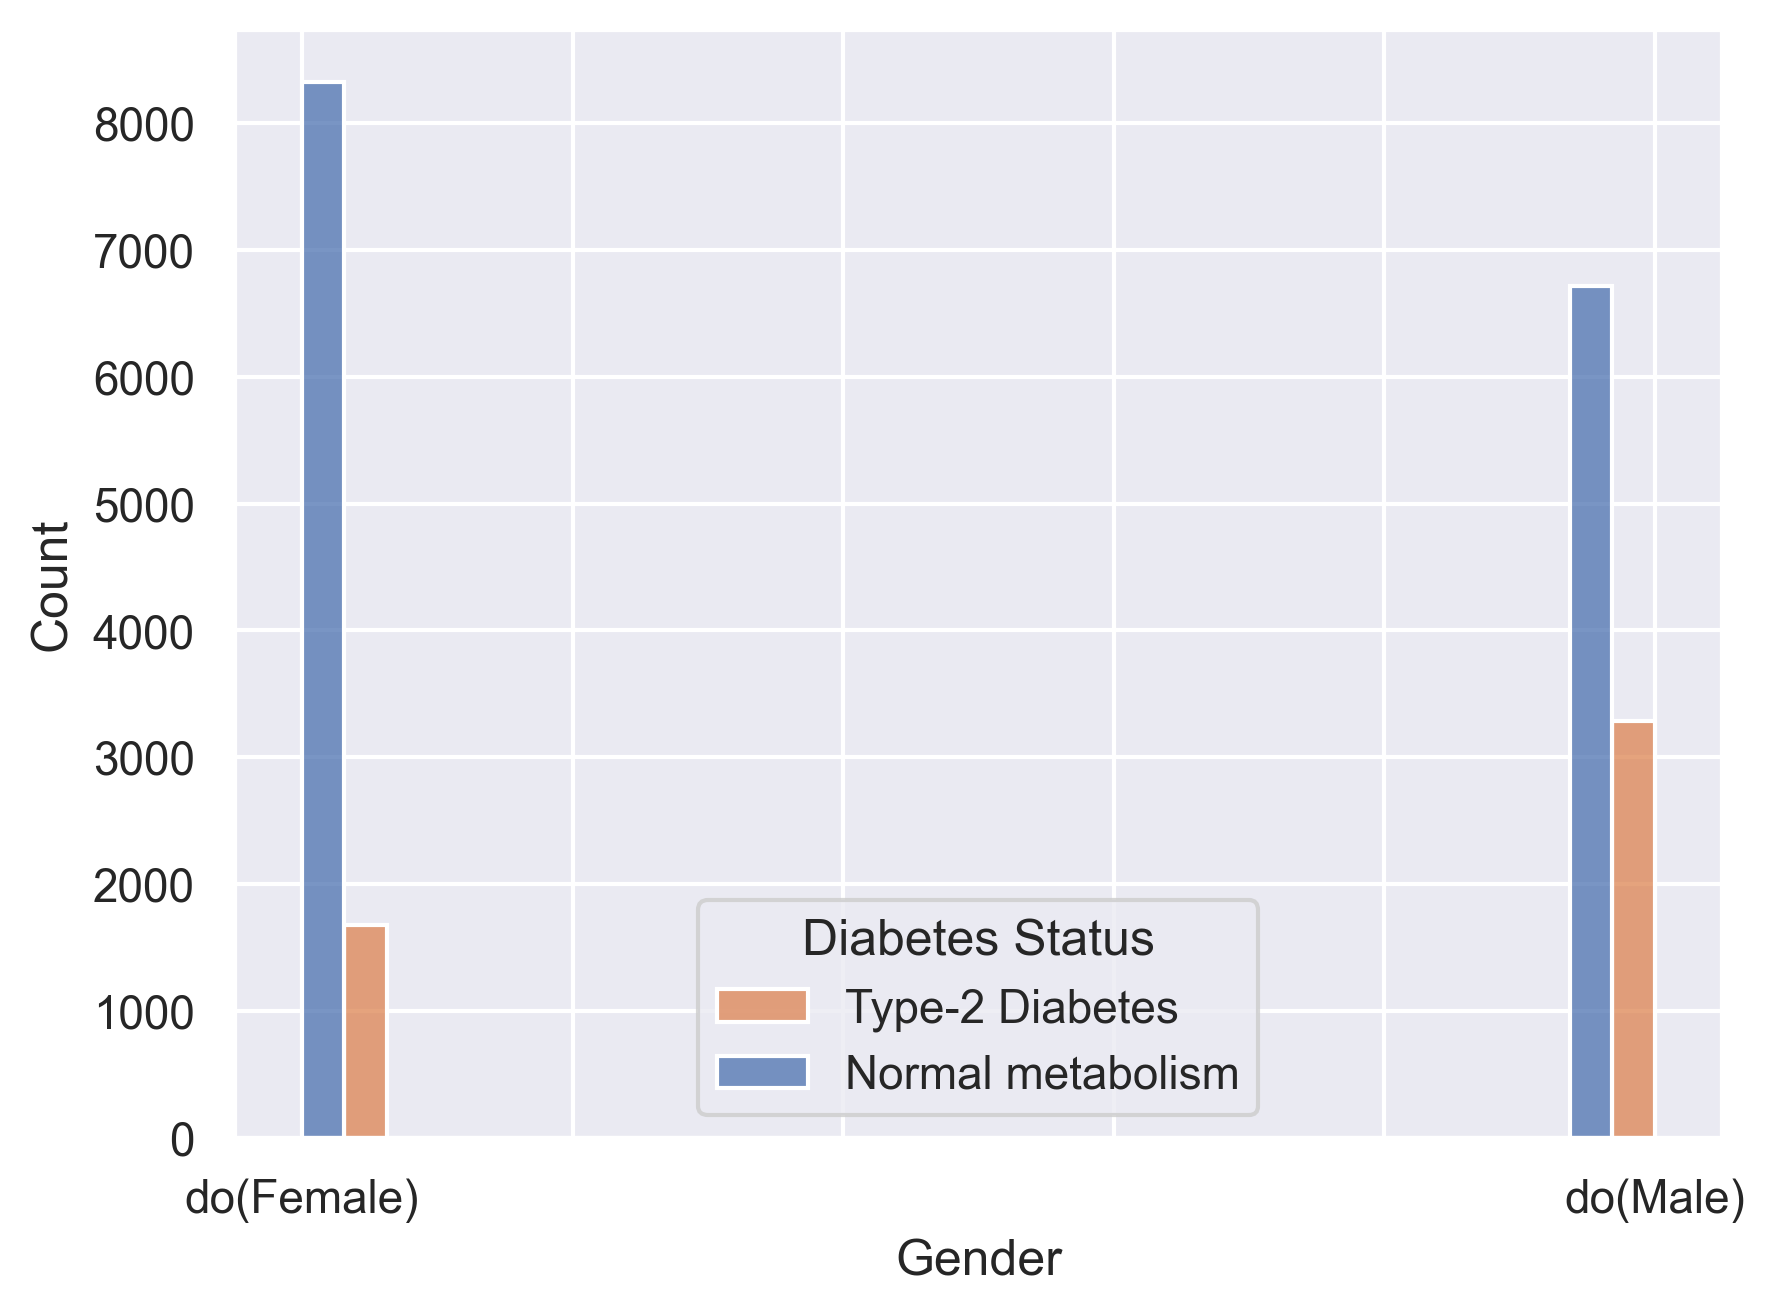

In [160]:
save_name = 'p_d_do_g'
d_g = torch.cat([d_g0, d_g1])
df_d_g = pd.DataFrame.from_dict({"T2D": d_g})
df_d_g['Gender']=0
df_d_g['Gender'][10000:20000]=1
ax = sns.histplot(data=df_d_g, x="Gender", hue="T2D", multiple="dodge", stat="count")
ax.set(xlabel='do(Gender:=Female(0.0), Male(1.0))')
ax.set(xlabel='Gender')
ax.set_xticklabels(['', 'do(Female)', '', '','', '', 'do(Male)', ''])

plt.legend(title='Diabetes Status', loc='lower center', labels=['Type-2 Diabetes', 'Normal metabolism'])

plt.savefig(f"{FIGURE_SAVE_PATH}/{save_name}.png")